In [11]:
import cv2


from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import pandas as pd

from toolbox import read_pixel_data, draw_loss_n_save
from config import *

## Load Data

In [12]:
train_X, train_y = read_pixel_data(part='train')
val_X, val_y = read_pixel_data(part='val')
test_X, test_y = read_pixel_data(part='test')
print(f"{'train_X shape':<15}: {train_X.shape}")
print(f"{'train_y shape':<15}: {train_y.shape}")
print(f"{'val_X shape':<15}: {val_X.shape}")
print(f"{'val_y shape':<15}: {val_y.shape}")
print(f"{'test_X shape':<15}: {test_X.shape}")
print(f"{'test_y shape':<15}: {test_y.shape}")

100%|██████████| 450/450 [00:00<00:00, 15388.43it/s]


train_X shape  : (63325, 3, 32, 32)
train_y shape  : (63325,)
val_X shape    : (450, 3, 32, 32)
val_y shape    : (450,)
test_X shape   : (450, 3, 32, 32)
test_y shape   : (450,)


In [13]:
train_y

array([ 0,  0,  0, ..., 49, 49, 49])

## Preprocessing

In [14]:
train_X = train_X / float(255)
val_X = val_X / float(255)
test_X = test_X / float(255)
train_X -= np.mean(train_X)
val_X -= np.mean(val_X)
test_X -= np.mean(test_X)

In [15]:
# tensor
train_X = torch.from_numpy(train_X).to(torch.float32)
train_y = torch.from_numpy(train_y)

val_X = torch.from_numpy(val_X).to(torch.float32)
val_y = torch.from_numpy(val_y)

test_X = torch.from_numpy(test_X).to(torch.float32)
test_y = torch.from_numpy(test_y)

# dataset
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

## Model

In [16]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet, self).__init__()
        self.conv_seq = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.Sigmoid(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 50)
        )
    
    def forward(self, X):
        h = self.conv_seq(X)
        h = self.flatten(h)
        out = self.mlp(h)
        pred_proba = nn.Softmax(dim=1)(out)
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet = Lenet().to(device)
optim = torch.optim.Adam(params=lenet.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', min_lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [17]:
lenet

Lenet(
  (conv_seq): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=50, bias=True)
  )
)

## Trainning

In [18]:
def valid(model, loss_fn, val_loader):
    model.eval()
    for (X, y) in val_loader: # only run one iter
        X, y = X.to(device), y.to(device)
        pred = model(X)
        val_loss = (loss_fn(pred, y).cpu().sum().item() * X.shape[0]) / len(val_loader.dataset)
        val_acc = (pred.argmax(dim=1) == y).cpu().sum().item() / len(val_loader.dataset)
        return  round(val_loss, 4), round(val_acc, 4)

In [19]:
def train(model, loss_fn, optim, train_loader, val_loader):
    ls_result = []
    model_best = None
    best_val_loss = 1e8
    for e in range(1, EPOCHS + 1):
        progress_loader = tqdm(enumerate(train_loader), desc=f"[Epoch {e}]", total=len(train_loader))
        train_loss = 0
        train_correct = 0
        for batch_i, (X, y) in progress_loader:
            model.train()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            train_correct += (pred.argmax(dim=1) == y).to('cpu').sum().item()
            train_loss += loss.item() * X.shape[0]
            progress_loader.set_postfix(loss=loss.item() / X.shape[0])
            if batch_i == len(train_loader) - 1:
                val_loss, val_acc = valid(model, loss_fn, val_loader)
                train_loss, train_acc = round(train_loss / len(train_loader.dataset), 4)\
                                        , round(train_correct / len(train_loader.dataset), 4)
                progress_loader.set_postfix(
                    train_loss=train_loss, train_acc=train_acc,
                    val_loss=val_loss, val_acc=val_acc)
                ls_result.append([train_loss, train_acc, val_loss, val_acc])
                if val_loss <= best_val_loss:
                    best_val_loss = val_loss
                    model_best = model
                scheduler.step(val_loss)
    return ls_result, model_best
        

In [20]:
ls_result, lenet_best = train(lenet, loss_fn, optim, train_loader, val_loader)

[Epoch 150]: 100%|██████████| 248/248 [00:01<00:00, 167.20it/s, train_acc=0.312, train_loss=2.49, val_acc=0.22, val_loss=2.75]


In [21]:
dict_hyper = {'v': 'Torch', 'e': EPOCHS, 'b': BATCH_SIZE, 'lr': LEARNING_RATE}

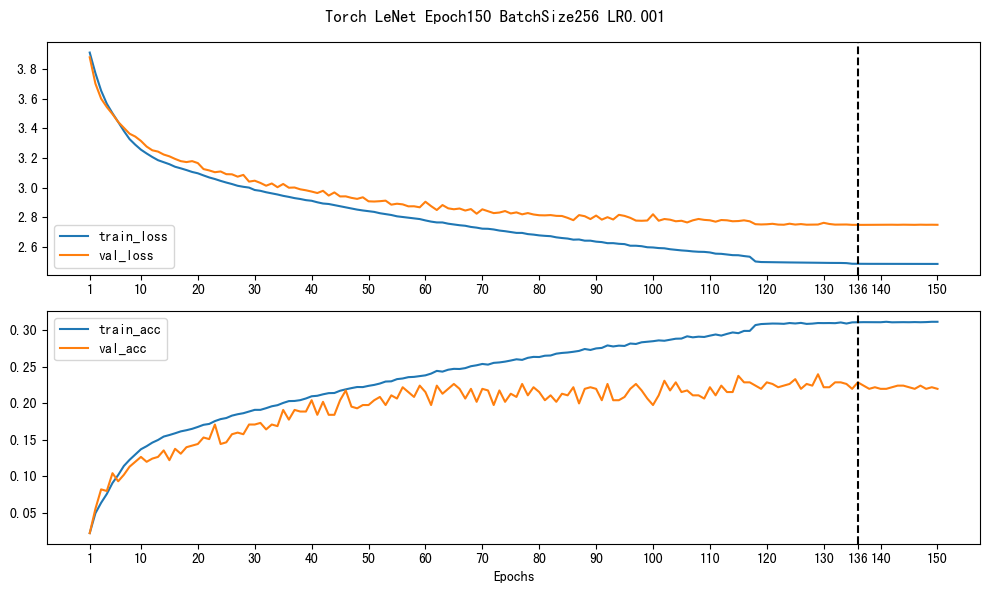

In [22]:
draw_loss_n_save(ls_result, dict_hyper)

## Test

In [23]:
pred_y = lenet_best(test_X.to(device))
test_acc = (pred_y.argmax(dim=1) == test_y.to(device)).cpu().detach().numpy().sum() / len(test_y)
print('Test Acc: ', round(test_acc, 4))

Test Acc:  0.2867


In [29]:
pd.DataFrame(ls_result, columns=['train_loss', 'train_acc', 'val_loss', 'val_acc']).reset_index(names='epoch')\
    .to_csv(f"{dict_hyper['v'].capitalize()}_LeNet_Epoch{dict_hyper['e']}_BatchSize{dict_hyper['b']}_LR{dict_hyper['lr']}.csv", index=False)